# NASA Nighttime Lights (Black Marble) data
This notebook downloads NASA nighttime lights data using Google Earth Engine, resamples it to match NDVI/Mapbiomas data, and creates maps and figures.

Citation: Román, M. O., Wang, Z., Sun, Q., Kalb, V., Miller, S. D., Molthan, A. L., Schultz, L., Bell, J., Stokes, E. C., Pandey, B., Seto, K. C., Hall, D. K., Oda, T., Wolfe, R. E., Lin, G., Golpayegani, N., Devadiga, S., Davidson, C., Sarkar, S., & Masuoka, E. J. (2018). NASA’s Black Marble nighttime lights product suite. Remote Sensing of Environment, 210, 113–143. https://doi.org/10.1016/j.rse.2018.03.017

In [8]:
#aggregate to year
def yearly_viirs(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end   = ee.Date.fromYMD(year, 12, 31)

    return (
        ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")
        .filterDate(start, end)
        .mean()
        .select("avg_rad")
        .toFloat()
        .clip(maranhao)
        .set("year", year)
    )


In [9]:
#Download to google drive from GEE
years = range(2012, 2024) 

for y in years:
    img = yearly_viirs(y)

    task = ee.batch.Export.image.toDrive(
        image=img,
        description=f"VIIRS_Maranhao_{y}",
        folder="viirs",
        fileNamePrefix=f"viirs_mar_{y}",
        region=maranhao.geometry(),
        scale=500,
        crs="EPSG:4326",
        maxPixels=1e13
    )
    task.start()

In [12]:
#Reproject VIIRS data to match NDVI
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import glob
import os

ndvi_ref = "maranhao_seasonal_ndvi_rasters/ndvi_rainy_mean_2020.tif"

with rasterio.open(ndvi_ref) as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_shape = (ref.height, ref.width)
    ref_profile = ref.profile.copy()

viirs_dir = "viirs"
viirs_out = "viirs_reproj_log"
os.makedirs(viirs_out, exist_ok=True)

for fp in glob.glob(f"{viirs_dir}/*.tif"):
    out_fp = os.path.join(viirs_out, os.path.basename(fp))

    with rasterio.open(fp) as src:
        src_data = src.read(1)
        dest = np.empty(ref_shape, dtype="float32")

        reproject(
            source=src_data,
            destination=dest,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.average
        )
        # log transform
        dest[dest < 0] = np.nan
        dest = np.log1p(dest)

        profile = ref.profile
        profile.update(dtype="float32", count=1)

        with rasterio.open(out_fp, "w", **profile) as dst:
            dst.write(dest, 1)



In [ ]:
#Stack all datasets for food security analysis
import rasterio
import numpy as np
import os

def stack_year(
    ndvi_fp,
    viirs_fp,
    lulc_fp,
    irrig_fp,
    out_fp
):
    with rasterio.open(ndvi_fp) as ndvi_src:
        ndvi = ndvi_src.read(1)
        profile = ndvi_src.profile.copy()

    viirs = rasterio.open(viirs_fp).read(1)
    lulc  = rasterio.open(lulc_fp).read(1)
    irrig = rasterio.open(irrig_fp).read(1)

    # Stack bands: (bands, rows, cols)
    stack = np.stack([
        ndvi.astype("float32"),
        viirs.astype("float32"),
        lulc.astype("float32"),
        irrig.astype("float32")
    ])

    profile.update(
        count=4,
        dtype="float32",
        nodata=np.nan,
        compress="lzw"
    )

    with rasterio.open(out_fp, "w", **profile) as dst:
        dst.write(stack)
        dst.set_band_description(1, "ndvi_rainy")
        dst.set_band_description(2, "viirs_log")
        dst.set_band_description(3, "mapbiomas_lulc")
        dst.set_band_description(4, "mapbiomas_irrig")

years = range(2012, 2024)
os.makedirs("stacked", exist_ok=True)

for y in years:
    ndvi_fp  = f"maranhao_ndvi_anomaly_rasters/ndvi_rainy_anomaly_{y}.tif"
    viirs_fp = f"viirs_reproj_log/viirs_mar_{y}.tif"
    lulc_fp  = f"mapbiomas_resampled/mapbiomas_lulc_{y}_resampled.tif"
    irrig_fp  = f"mapbiomas_resampled/mapbiomas_irrigation_{y}_resampled.tif"
    out_fp   = f"stacked/ndvi_viirs_lulc_{y}.tif"

    if not (os.path.exists(ndvi_fp) and
            os.path.exists(viirs_fp) and
            os.path.exists(irrig_fp) and
            os.path.exists(lulc_fp)):

    stack_year(ndvi_fp, viirs_fp, lulc_fp, irrig_fp, out_fp)



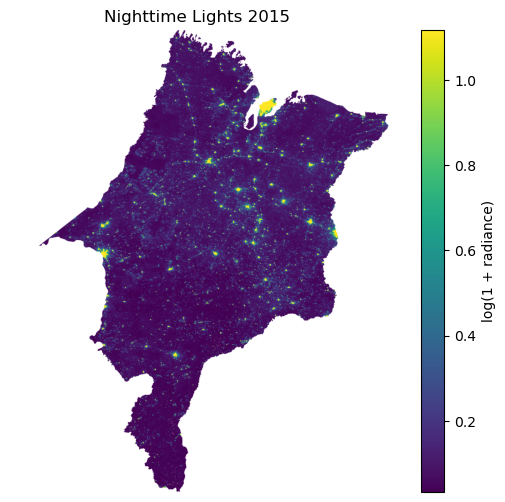

In [33]:
#Exploratory analysis - plot nighttime lights for Maranhao
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask

maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp")

y = 2015
fp = "viirs_reproj_log"
nl_path = f"{fp}/viirs_mar_{y}.tif"

def show(path, title, boundary_gdf):
    with rasterio.open(path) as ds:
        a = ds.read(1).astype("float32")
        mask = geometry_mask(
            boundary_gdf.geometry,
            transform=ds.transform,
            invert=True,
            out_shape=a.shape
        )
        a[~mask] = np.nan
        
    vmin = np.nanpercentile(a, 5)
    vmax = np.nanpercentile(a, 99)

    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")

    plt.figure(figsize=(8,6))
    plt.imshow(a, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label="log(1 + radiance)")
    plt.show()

show(nl_path, f"Nighttime Lights {y} ", maranhao)

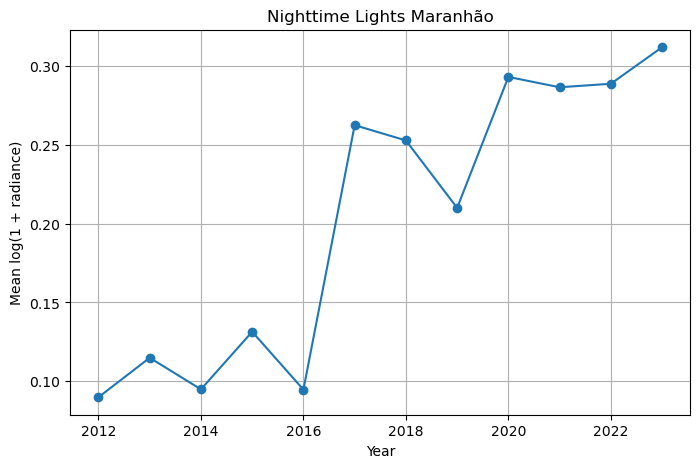

In [32]:
#Plot time series of nighttime lights for 2012-2023
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask
import glob
import pandas as pd
import matplotlib.pyplot as plt
#shapefile
maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp")

records = []

for fp in sorted(glob.glob("viirs_reproj_log/viirs_mar_*.tif")):
    year = int(fp.split("_")[-1].replace(".tif", ""))

    with rasterio.open(fp) as ds:
        a = ds.read(1)

        mask = geometry_mask(
            maranhao.geometry,
            transform=ds.transform,
            invert=True,
            out_shape=a.shape
        )

        a = np.where(mask, a, np.nan)
        mean_ntl = np.nanmean(a)

    records.append({"year": year, "ntl_mean": mean_ntl})

df_ntl = pd.DataFrame(records).sort_values("year")
#Plot figure
plt.figure(figsize=(8,5))
plt.plot(df_ntl["year"], df_ntl["ntl_mean"], marker="o")
plt.xlabel("Year")
plt.ylabel("Mean log(1 + radiance)")
plt.title("Nighttime Lights Maranhão")
plt.grid(True)
plt.show()


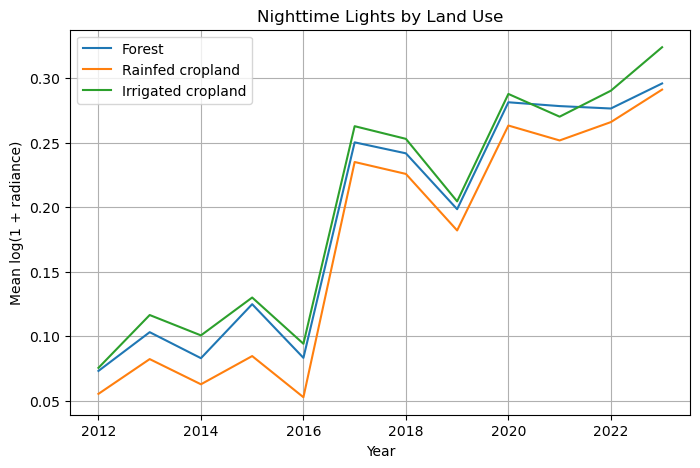

In [36]:
#Plot time series of nighttime lights by LULC/irrigation
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask
import glob
import pandas as pd
import matplotlib.pyplot as plt

maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp")
AG_CODES = [18, 19, 20, 35, 36, 39, 40, 41, 46, 47, 48]
FOREST_CODES = [1, 3, 6, 9]

records = []

for y in range(2012, 2024):
    nl_fp   = f"viirs_reproj_log/viirs_mar_{y}.tif"
    lulc_fp = f"mapbiomas_resampled/mapbiomas_lulc_{y}_resampled.tif"
    irrig_fp = f"mapbiomas_resampled/mapbiomas_irrigation_{y}_resampled.tif"

    with rasterio.open(nl_fp) as nl, rasterio.open(lulc_fp) as lu, rasterio.open(irrig_fp) as ir:
        ntl = nl.read(1)
        lulc = lu.read(1)
        irrig = ir.read(1)

    cropland_mask  = np.isin(lulc, AG_CODES)
    forest_mask    = np.isin(lulc, FOREST_CODES)
    irrigated_mask = cropland_mask & (irrig > 0)
    rainfed_mask   = cropland_mask & (irrig == 0)

    records.append({
        "year": y,
        "cropland": np.nanmean(ntl[cropland_mask]),
        "forest":   np.nanmean(ntl[forest_mask]),
        "irrigated":   np.nanmean(ntl[irrigated_mask]),
        "rainfed":   np.nanmean(ntl[rainfed_mask])
    })

df = pd.DataFrame(records)

plt.figure(figsize=(8,5))
plt.plot(df.year, df.forest, label="Forest")
plt.plot(df.year, df.rainfed, label="Rainfed cropland")
plt.plot(df.year, df.irrigated, label="Irrigated cropland")
plt.ylabel("Mean log(1 + radiance)")
plt.xlabel("Year")
plt.title("Nighttime Lights by Land Use")
plt.legend()
plt.grid(True)
plt.show()
